# Gamma Ray Burst

Some relevant questions you may want to answer:
- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [40]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib.colors import ListedColormap

In [2]:
#I define the function for genereting the distribution of log(T90) using a KDE
def KDE(data, grid, bandwidth, kernel):    
   KDE = KernelDensity(bandwidth=bandwidth, kernel= kernel) 
   KDE.fit(data) #Sklearn returns log(density)
   return np.exp(KDE.score_samples(grid[:, np.newaxis]))

In [4]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [5]:
names


array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [6]:
T0 = np.array(data[2],dtype=str) #This time corresponds to the earliest trigger time of the satellites or the start of the T90 interval if it preceeds those trigger time
ra = np.array(data[3],dtype=float)
dec = np.array(data[4],dtype=float)
pos_err = np.array(data[5],dtype=str) #1σ error on the localisation.
T90_data = np.array(data[6],dtype=float) #Duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%. 
T90_err_data = np.array(data[7],dtype=float) #Estimated 1σ error
T_90_start = np.array(data[8],dtype=str) #UTC time that marks the start of the T90 interval.
fluence_data = np.array(data[9],dtype=float) #The time integrated total energy per unit surface (flux integrated over time)
fluence_err_data = np.array(data[10],dtype=float) #Estimated 1σ error on the fluence.
z_data = np.array(data[11],dtype=float) #Redshift
T100 = np.array(data[12],dtype=float) #Total time during which the GRB was observed. 
                                      #In practice, this variable is obtained by subtracting the earliest trigger time from the latest end of the T90 intervals.
#To avoid errors of the instruments
T90_mask = T90_data > 0
T90 = T90_data[T90_mask]
T90_err = T90_err_data[T90_mask]

fluence_mask = fluence_data > 0
fluence = fluence_data[fluence_mask]
fluence_err = fluence_err_data[fluence_mask]

z_mask = z_data > 0
z = z_data[z_mask]

### Visualization of the data

(array([0.38684151, 0.18625703, 0.22923942, 0.40116898, 0.37251405,
        0.3152042 , 0.3152042 , 0.38684151, 0.37251405, 0.35818659,
        0.34385912, 0.35818659, 0.35818659, 0.35818659, 0.18625703,
        0.20058449, 0.18625703, 0.18625703, 0.3152042 , 0.20058449,
        0.17192956, 0.28654927, 0.28654927, 0.14327463, 0.21491195,
        0.1576021 , 0.10029224, 0.11461971, 0.10029224, 0.10029224,
        0.12894717, 0.11461971, 0.11461971, 0.04298239, 0.08596478,
        0.07163732, 0.12894717, 0.04298239, 0.04298239, 0.02865493,
        0.04298239, 0.02865493, 0.08596478, 0.02865493, 0.04298239,
        0.04298239, 0.01432746, 0.04298239, 0.01432746, 0.        ,
        0.04298239, 0.01432746, 0.        , 0.01432746, 0.01432746,
        0.01432746, 0.        , 0.02865493, 0.        , 0.01432746,
        0.        , 0.01432746, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01432746, 0.        ,
        0.01432746, 0.01432746, 0.01432746, 0.  

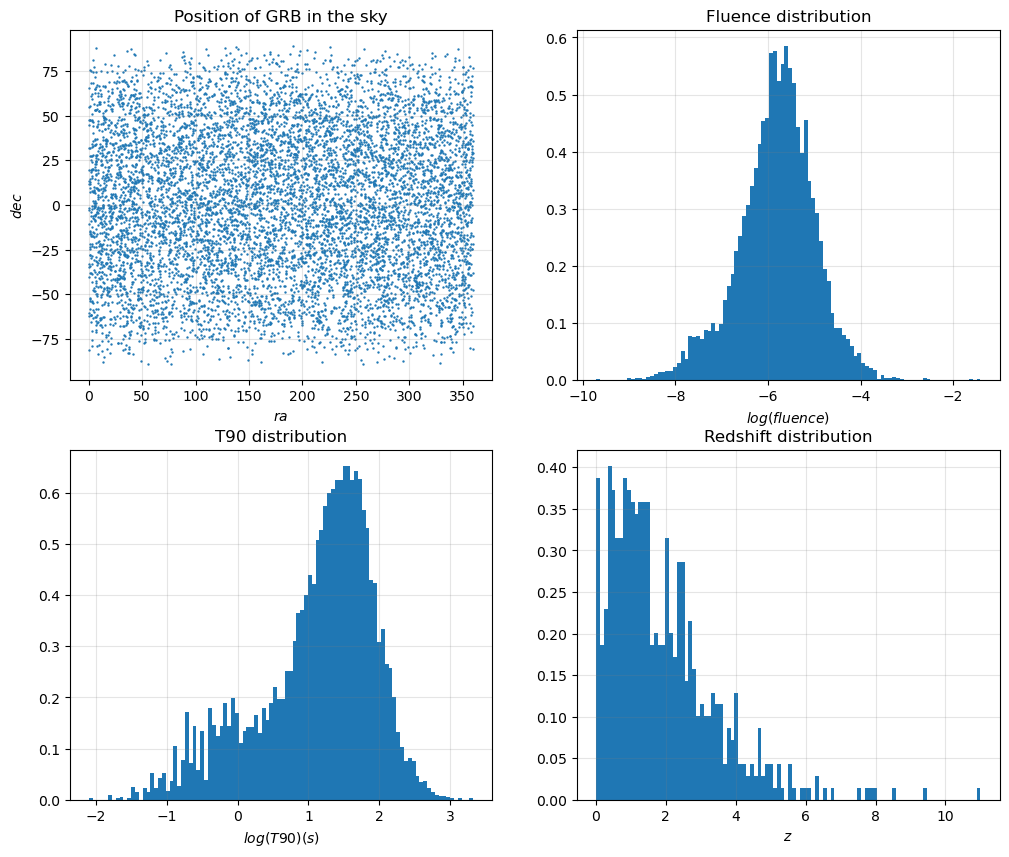

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0,0].grid(c='grey', alpha = 0.2)
ax[0,0].set_title('Position of GRB in the sky')
ax[0,0].set_xlabel('$ra$')
ax[0,0].set_ylabel('$dec$')
ax[0,0].scatter(ra, dec, s=0.5)

ax[0,1].grid(c='grey', alpha = 0.2)
ax[0,1].set_title('Fluence distribution')
ax[0,1].set_xlabel('$log(fluence)$')
ax[0,1].hist(np.log10(fluence), bins=100, density=True)

ax[1,0].grid(c='grey', alpha = 0.2)
ax[1,0].set_title('T90 distribution')
ax[1,0].set_xlabel('$log(T90) (s)$')
ax[1,0].hist(np.log10(T90), bins=100, density=True)

ax[1,1].grid(c='grey', alpha = 0.2)
ax[1,1].set_title('Redshift distribution')
ax[1,1].set_xlabel('$z$')
ax[1,1].hist(z, bins=100, density=True)

GRB are classified as 'long' and 'short' depending on the value of T90: 
- if T90 < 2 seconds, we talk about short GRB, the maximum is around 1s.
- if T90 > 2 seconds, we talk about long GRB, the maxima is around 100s.
  
We want to show this bimodality by fitting a Gaussian Mixture model with two gaussians.

### GaussianMixture

C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\190751722.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = np.arange(min(T90_reshaped), max(T90_reshaped), 0.01) #X axis
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\190751722.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax5.axvline(means_T90[0], c='orange', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**means_T90[0])
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\190751722.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing 

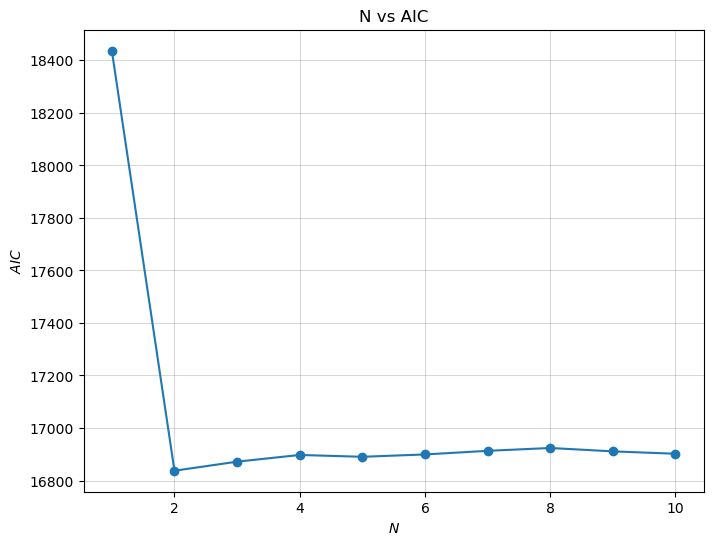

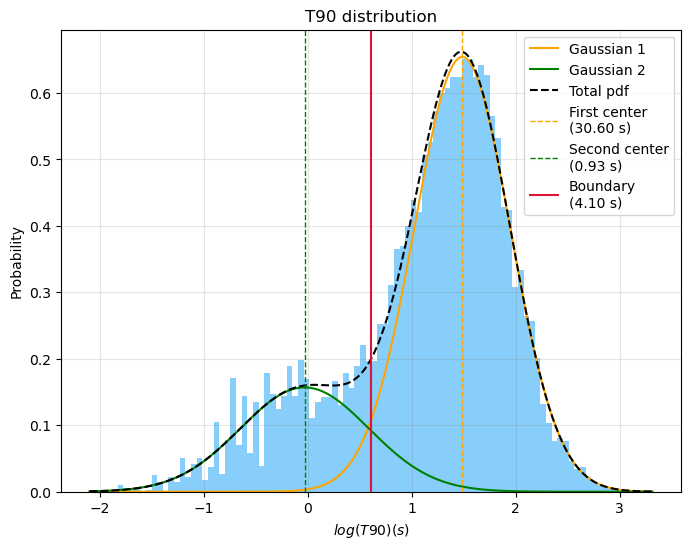

In [18]:
log_T90= np.log10(T90)
T90_clean = log_T90[~np.isnan(log_T90)]
#Reshaped T90 because GaussianMixture requires (N,1) type of data
T90_reshaped = T90_clean[:, np.newaxis]

#Evaluation of AIC to find the best fit (changing the number of gaussians n) 
aic=[]   
for i in range(1, 11):
    gm = GaussianMixture(n_components=i, random_state=0).fit(T90_reshaped)
    aic.append(gm.aic(T90_reshaped))

n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#Plot AIC vs N 
fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.gca()
ax4.grid(alpha=0.3, c = 'grey')
ax4.set_xlabel('$N$')
ax4.set_ylabel('$AIC$')
ax4.set_title('N vs AIC')
ax4.plot(n, aic, marker = 'o')

N = n[np.argmin(aic)] #Number of Gaussian components that correspond to the smallest AIC

gm = GaussianMixture(n_components=N, random_state=0).fit(T90_reshaped)
labels_gm = GaussianMixture(n_components=N, random_state=0).fit_predict(T90_reshaped)
boundary_gm = (np.mean([max(T90_reshaped[labels_gm==0]), min(T90_reshaped[labels_gm==1])])) #Boundary between the two samples 

#Plot the histogram of logT90
fig5 = plt.figure(figsize=(8,6))
ax5 = fig5.gca()
ax5.grid(c='grey', alpha = 0.2)
ax5.set_title('T90 distribution')
ax5.set_xlabel('$log(T90) (s)$')
ax5.hist(log_T90, bins=100, density=True, color ='lightskyblue')
ax5.set_ylabel('Probability')

x = np.arange(min(T90_reshaped), max(T90_reshaped), 0.01) #X axis

#Plot the components
y= []
colors= ['orange', 'green']
for i in range(N):
    y.append(norm.pdf(x, gm.means_[i], np.sqrt(gm.covariances_[i][0]))*gm.weights_[i]) 
    ax5.plot(x, y[i], label ='Gaussian '+ str(i+1), color=colors[i]) #Rappresentation of the Gaussian on the histogram 
    
somma = sum(y)

ax5.plot(x, somma, color = 'black', linestyle='--', label = 'Total pdf')
ax5.legend()

#We can also show the means of the two gaussians and the boundary of the samples
means_T90 = gm.means_
ax5.axvline(means_T90[0], c='orange', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**means_T90[0])
ax5.axvline(means_T90[1], c='green', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % 10**means_T90[1])
ax5.axvline(boundary_gm, c='crimson', label = 'Boundary\n(%.2f s)' % 10**boundary_gm)
ax5.legend()

We see clearly both from the AIC and the histogram that the distribution presents two componets.

We can also use a density extimator KDE to extimate the density of the distribution and fit with data.

### KDE

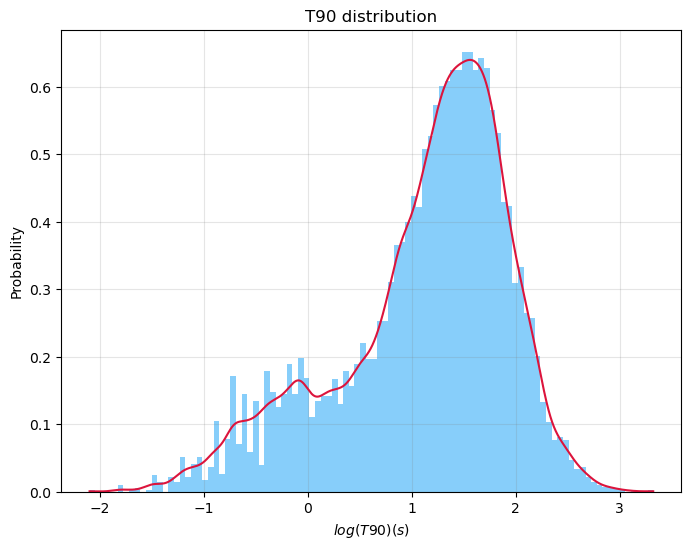

In [11]:
t90grid = np.linspace(T90_clean.min(), T90_clean.max(), 7530)  

fig7 = plt.figure(figsize=(8,6))
ax7 = fig7.gca()
ax7.grid(c='grey', alpha = 0.2)
ax7.set_title('T90 distribution')
ax7.set_xlabel('$log(T90) (s)$')
ax7.hist(log_T90, bins=100, density=True, color ='lightskyblue')
ax7.set_ylabel('Probability')

#I plot it using gaussian kernel, data are the log(T90) reshaped
kde_gauss = KDE(T90_reshaped, t90grid, 0.08, kernel = 'gaussian')
ax7.plot(t90grid, kde_gauss, color = 'crimson', label='Gaussian')


Now we want to find which is the threshold that from literature should be 2 seconds.
We perform two clustering methods: K_means Clustering and Mean-shift Clustering 

### K-means clustering

In [12]:
#K-means clustering
clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(T90_reshaped)

KMeans(n_clusters=2, n_init='auto')

centers without squeeze: [[-0.05675482]
 [ 1.51563252]]
Correct centers order: [-0.05675482  1.51563252]
[0.72916479] [0.72997429] 0.7295695376961628 [-0.05675482  1.51563252]


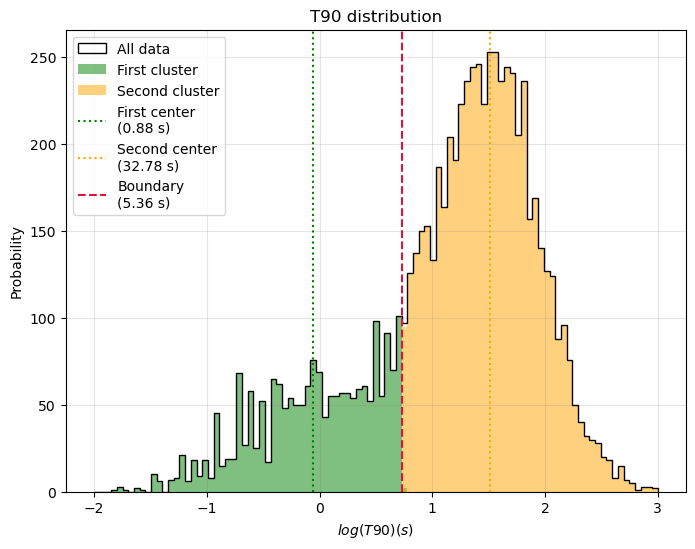

In [13]:
centers_km = clf.cluster_centers_ #Location of the centers of the two clusters
labels_km = clf.predict(T90_reshaped) #Labels for each of the points
print('centers without squeeze:', centers_km)
centers_km = np.squeeze(centers_km)

if centers_km[0]>centers_km[1]:
    centers_km=centers_km[::-1] # Reverse array
    labels_km = np.array(~np.array(labels_km,dtype='bool'),dtype='int') # Swap 0 <--> 1
print('Correct centers order:', centers_km)

#Boundary of the two samples
boundary_km = (np.mean( [max(T90_reshaped[labels_km==0]), min(T90_reshaped[labels_km==1]) ]))

print(max(T90_reshaped[labels_km==0]), min(T90_reshaped[labels_km==1]), boundary_km, centers_km)

fig8 = plt.figure(figsize=(8,6))
ax8 = fig8.gca()
ax8.grid(c='grey', alpha = 0.2)
ax8.set_title('T90 distribution')
ax8.set_xlabel('$log(T90) (s)$')
ax8.hist(T90_reshaped, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
ax8.set_ylabel('Probability')
    
ax8.hist(T90_reshaped[labels_km==0], bins=np.linspace(-2, 3, 100), color='green', alpha = 0.5, label = 'First cluster')
ax8.hist(T90_reshaped[labels_km==1], bins=np.linspace(-2, 3, 100), color='orange', alpha = 0.5, label = 'Second cluster') 

ax8.axvline(centers_km[0], c= 'green', ls='dotted', label = 'First center\n(%.2f s)' % 10**centers_km[0])

ax8.axvline(centers_km[1], c= 'orange', ls='dotted', label = 'Second center\n(%.2f s)' % 10**centers_km[1])
ax8.axvline(boundary_km,c='crimson',ls='dashed', label = 'Boundary\n(%.2f s)' % 10**boundary_km)

ax8.legend()

### Means-shift clustering

In [17]:
#Mean-shift Clustering
scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(T90_reshaped)
ms = MeanShift(bandwidth=bandwidth)
ms.fit(scaler.fit_transform(T90_reshaped))

MeanShift(bandwidth=0.5186114534155003)

Correct centers order: [[-0.0027442 ]
 [ 1.50123639]]
[0.74818803] [0.75066265] 0.749425336570128 [[-0.0027442 ]
 [ 1.50123639]]


C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3528696580.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax9.axvline(centers_ms[0], c= 'green', ls='dotted', label = 'First center\n(%.2f s)' % 10**centers_ms[0])
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3528696580.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax9.axvline(centers_ms[1], c= 'orange', ls='dotted', label = 'Second center\n(%.2f s)' % 10**centers_ms[1])


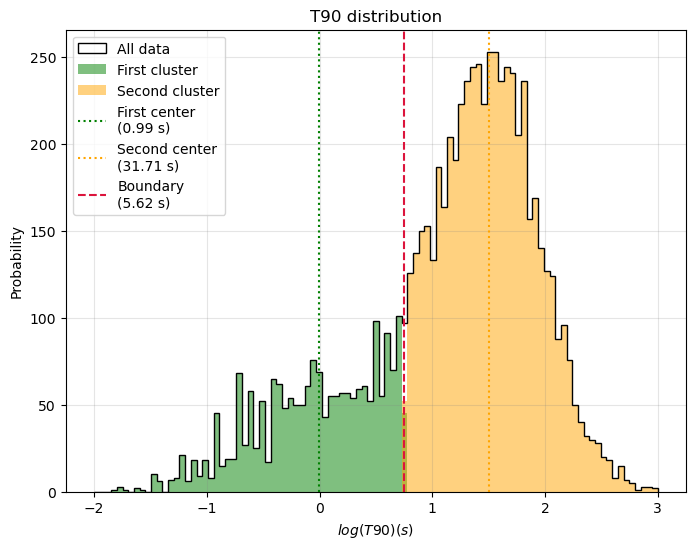

In [22]:
scaled_centers_ms = ms.cluster_centers_ #Location of the centers of the two clusters
labels_ms = ms.labels_ #Labels for each of the points

centers_ms = scaler.inverse_transform(scaled_centers_ms)

if centers_ms[0]>centers_ms[1]:
    centers_ms=centers_ms[::-1] # Reverse array
    labels_ms = np.array(~np.array(labels_ms,dtype='bool'),dtype='int') # Swap 0 <--> 1
print('Correct centers order:', centers_ms)

#Boundary of the two samples
boundary_ms = (np.mean( [max(T90_reshaped[labels_ms==0]), min(T90_reshaped[labels_ms==1]) ]))

print(max(T90_reshaped[labels_ms==0]), min(T90_reshaped[labels_ms==1]), boundary_ms, centers_ms)

fig9 = plt.figure(figsize=(8,6))
ax9 = fig9.gca()
ax9.grid(c='grey', alpha = 0.2)
ax9.set_title('T90 distribution')
ax9.set_xlabel('$log(T90) (s)$')
ax9.hist(T90_reshaped, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
ax9.set_ylabel('Probability')
    
ax9.hist(T90_reshaped[labels_ms==0], bins=np.linspace(-2, 3, 100), color='green', alpha = 0.5, label = 'First cluster')
ax9.hist(T90_reshaped[labels_ms==1], bins=np.linspace(-2, 3, 100), color='orange', alpha = 0.5, label = 'Second cluster') 

ax9.axvline(centers_ms[0], c= 'green', ls='dotted', label = 'First center\n(%.2f s)' % 10**centers_ms[0])

ax9.axvline(centers_ms[1], c= 'orange', ls='dotted', label = 'Second center\n(%.2f s)' % 10**centers_ms[1])
ax9.axvline(boundary_ms,c='crimson',ls='dashed', label = 'Boundary\n(%.2f s)' % 10**boundary_ms)

ax9.legend()

### Summary

In [23]:
#We can compare the boundary and the maxima of the two samples found in the three methods.
print('METHOD\t\tMAXIMA(s)\t\tDECISION BOUNDARY(s)')
print('GMM\t\t%.2f  -  %.2f\t\t%.2f' % (10**means_T90[1], 10**means_T90[0], 10**boundary_gm))
print('KM\t\t%.2f  -  %.2f\t\t%.2f' % (10**centers_km[0], 10**centers_km[1], 10**boundary_km))
print('MS\t\t%.2f  -  %.2f\t\t%.2f' % (10**centers_ms[0], 10**centers_ms[1], 10**boundary_ms))

METHOD		MAXIMA(s)		DECISION BOUNDARY(s)
GMM		0.93  -  30.60		4.10
KM		0.88  -  32.78		5.36
MS		0.99  -  31.71		5.62


C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3983190081.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('GMM\t\t%.2f  -  %.2f\t\t%.2f' % (10**means_T90[1], 10**means_T90[0], 10**boundary_gm))
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3983190081.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MS\t\t%.2f  -  %.2f\t\t%.2f' % (10**centers_ms[0], 10**centers_ms[1], 10**boundary_ms))


### Redshift
How are the two samples distributed in redshifts?

C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\1094975576.py:7: RuntimeWarning: invalid value encountered in log10
  ax10.scatter(np.log10(T90_data), z_data)


(0.0, 4.0)

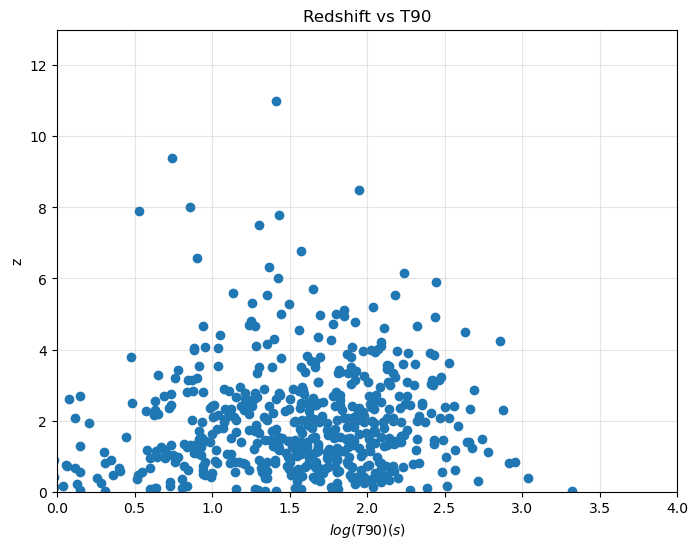

In [38]:
fig10 = plt.figure(figsize=(8,6))
ax10 = fig10.gca()
ax10.grid(c='grey', alpha = 0.2)
ax10.set_title('Redshift vs T90')
ax10.set_xlabel('$log(T90)(s)$')
ax10.set_ylabel('z')
ax10.scatter(np.log10(T90_data), z_data)
ax10.set_ylim(0, 13)
ax10.set_xlim(0, 4)

The long sample is present at both high and low redshift, instead, the short one are more likely to be find a low redshift. We can show the two samples found through the three clustering methods in this plot. 


Threshold: 4.10
Threshold: 5.36
Threshold: 5.62


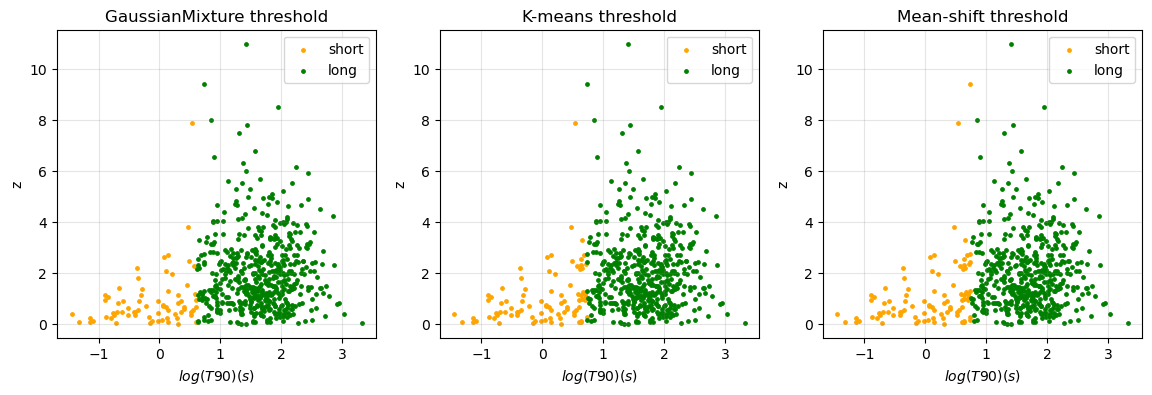

In [77]:
threshold_gm = 10**boundary_gm
print('Threshold: %.2f' % threshold_gm)

mask_short_gm = np.logical_and(np.logical_and(T90_data>0, T90_data<threshold_gm), z_data>0)
mask_long_gm = np.logical_and(np.logical_and(T90_data>0, T90_data>threshold_gm), z_data>0)

threshold_km = 10**boundary_km
print('Threshold: %.2f' % threshold_km)

mask_short_km = np.logical_and(np.logical_and(T90_data>0, T90_data<threshold_km), z_data>0)
mask_long_km = np.logical_and(np.logical_and(T90_data>0, T90_data>threshold_km), z_data>0)

threshold_ms = 10**boundary_ms
print('Threshold: %.2f' % threshold_ms)

mask_short_ms = np.logical_and(np.logical_and(T90_data>0, T90_data<threshold_ms), z_data>0)
mask_long_ms = np.logical_and(np.logical_and(T90_data>0, T90_data>threshold_ms), z_data>0)

fig2, ax2 = plt.subplots(1, 3, figsize=(14, 4))

ax2[0].grid(c='grey', alpha = 0.2)
ax2[0].set_title('GaussianMixture threshold')
ax2[0].set_xlabel('$log(T90)(s)$')
ax2[0].set_ylabel('z')
ax2[0].scatter(np.log10(T90_data[mask_short_gm]), z_data[mask_short_gm], c='orange', s=6, label='short')
ax2[0].scatter(np.log10(T90_data[mask_long_gm]), z_data[mask_long_gm], c='green', s=6, label='long')
ax2[0].legend()

ax2[1].grid(c='grey', alpha = 0.2)
ax2[1].set_title('K-means threshold')
ax2[1].set_xlabel('$log(T90)(s)$')
ax2[1].set_ylabel('z')
ax2[1].scatter(np.log10(T90_data[mask_short_km]), z_data[mask_short_km], c='orange', s=6, label='short')
ax2[1].scatter(np.log10(T90_data[mask_long_km]), z_data[mask_long_km], c='green', s=6, label='long')
ax2[1].legend()

ax2[2].grid(c='grey', alpha = 0.2)
ax2[2].set_title('Mean-shift threshold')
ax2[2].set_xlabel('$log(T90)(s)$')
ax2[2].set_ylabel('z')
ax2[2].scatter(np.log10(T90_data[mask_short_ms]), z_data[mask_short_ms], c='orange', s=6, label='short')
ax2[2].scatter(np.log10(T90_data[mask_long_ms]), z_data[mask_long_ms], c='green', s=6, label='long')
ax2[2].legend()

These three plots confirm what we said about the redshift division: in all of the three clustering methods we have that the short GRB are more likely to be at lower redshift then the longer ones.

### What about the fluence?
Till now we analize only the T90 distribution searching for two different clusters. Is it the same for the fluence?

#### KDE fluence

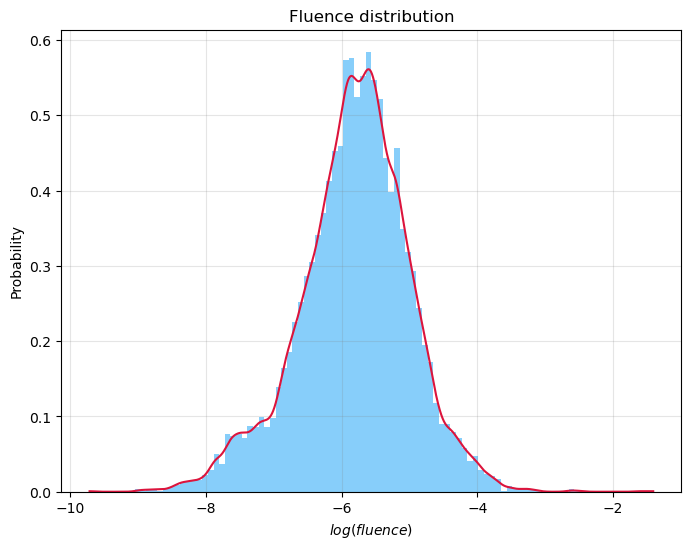

In [80]:
log_fluence= np.log10(fluence)
fluence_clean = log_fluence[~np.isnan(log_fluence)]

#Reshaped T90 because sklearn requires (N,1) type of data
fluence_reshaped = fluence_clean[:, np.newaxis]

fluencegrid = np.linspace(fluence_clean.min(), fluence_clean.max(), 7530)  

fig12 = plt.figure(figsize=(8,6))
ax12 = fig12.gca()
ax12.grid(c='grey', alpha = 0.2)
ax12.set_title('Fluence distribution')
ax12.set_xlabel('$log(fluence)$')
ax12.hist(log_fluence, bins=100, density=True, color ='lightskyblue')
ax12.set_ylabel('Probability')

#I plot it using gaussian kernel, data are the log(T90) reshaped
kde_gauss_f = KDE(fluence_reshaped, fluencegrid, 0.08, kernel = 'gaussian')
ax12.plot(fluencegrid, kde_gauss_f, color = 'crimson', label='Gaussian')

### GaussianMixture

C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\2787461721.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = np.arange(min(fluence_reshaped), max(fluence_reshaped), 0.01) #X axis
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\2787461721.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax13.axvline(means_fluence[0], c='orange', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % means_fluence[0])
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\2787461721.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array be

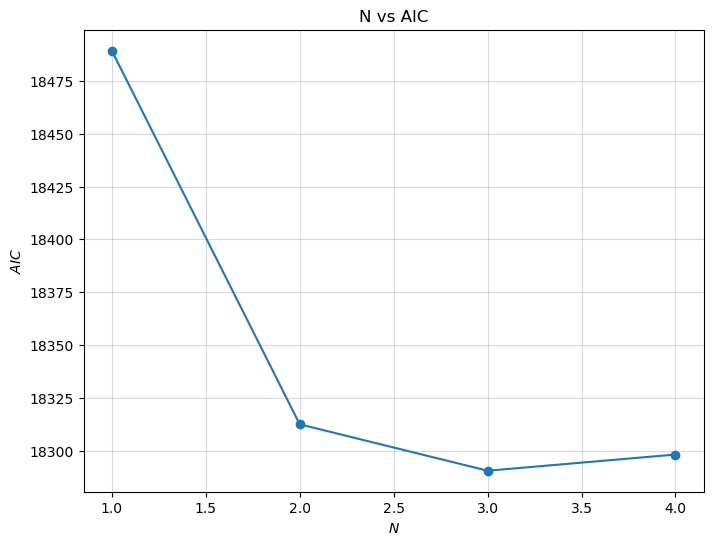

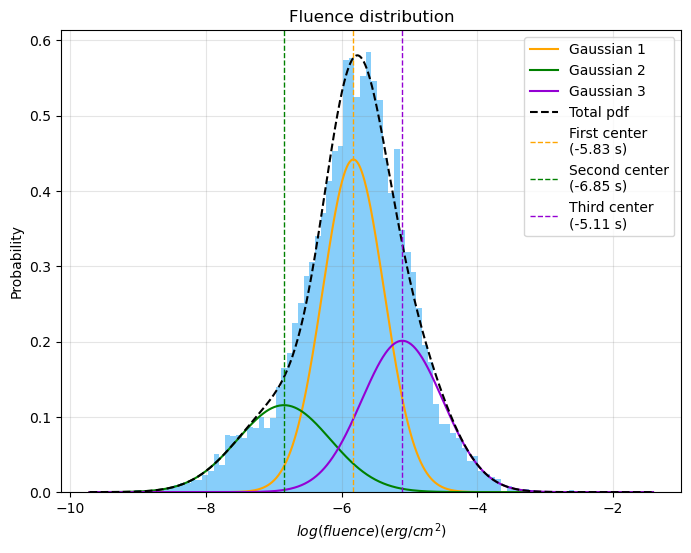

In [116]:
#Evaluation of AIC to find the best fit (changing the number of gaussians n) 
aic_f=[]   
for i in range(1, 5):
    gm_f = GaussianMixture(n_components=i, random_state=0).fit(fluence_reshaped)
    aic_f.append(gm_f.aic(fluence_reshaped))

n = [1, 2, 3, 4]

#Plot AIC vs N 
fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.gca()
ax4.grid(alpha=0.3, c = 'grey')
ax4.set_xlabel('$N$')
ax4.set_ylabel('$AIC$')
ax4.set_title('N vs AIC')
ax4.plot(n, aic_f, marker = 'o')

N = n[np.argmin(aic_f)] #Number of Gaussian components that correspond to the smallest AIC

gm_f = GaussianMixture(n_components=N, random_state=0).fit(fluence_reshaped)
labels_gm_f = GaussianMixture(n_components=N, random_state=0).fit_predict(fluence_reshaped)
#boundary_gm_f = (np.mean([max(fluence_reshaped[labels_gm_f==0]), min(fluence_reshaped[labels_gm_f==1])])) #Boundary between the t samples 

#Plot the histogram of logT90
fig13 = plt.figure(figsize=(8,6))
ax13 = fig13.gca()
ax13.grid(c='grey', alpha = 0.2)
ax13.set_title('Fluence distribution')
ax13.set_xlabel('$log(fluence)(erg/cm^2)$')
ax13.hist(log_fluence, bins=100, density=True, color ='lightskyblue')
ax13.set_ylabel('Probability')

x = np.arange(min(fluence_reshaped), max(fluence_reshaped), 0.01) #X axis

#Plot the components
y= []
colors= ['orange', 'green', 'darkviolet']
for i in range(N):
    y.append(norm.pdf(x, gm_f.means_[i], np.sqrt(gm_f.covariances_[i][0]))*gm_f.weights_[i]) 
    ax13.plot(x, y[i], label ='Gaussian '+ str(i+1), color=colors[i]) #Rappresentation of the Gaussian on the histogram 
    
somma = sum(y)

ax13.plot(x, somma, color = 'black', linestyle='--', label = 'Total pdf')
ax13.legend()

#We can also show the means of the two gaussians and the boundary of the samples
means_fluence = gm_f.means_
ax13.axvline(means_fluence[0], c='orange', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % means_fluence[0])
ax13.axvline(means_fluence[1], c='green', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % means_fluence[1])
ax13.axvline(means_fluence[2], c='darkviolet', lw = 1, ls = '--', label = 'Third center\n(%.2f s)' % means_fluence[2])
#ax5.axvline(boundary_gm_f, c='crimson', label = 'Boundary\n(%.2f s)' % 10**boundary_gm_f)
ax13.legend()

Already with the GaussianMixture method we have found three clusters and not two! We can try with k-means.

### K-means clustering fluence

In [96]:
#K-means clustering
clf_f = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf_f.fit(fluence_reshaped)

KMeans(n_clusters=2, n_init='auto')

Centers without squeeze: [[-6.60644714]
 [-5.31363685]]
Correct centers order: [-6.60644714 -5.31363685]
[-5.96014982] [-5.95991216] -5.960030989390228 [-6.60644714 -5.31363685]


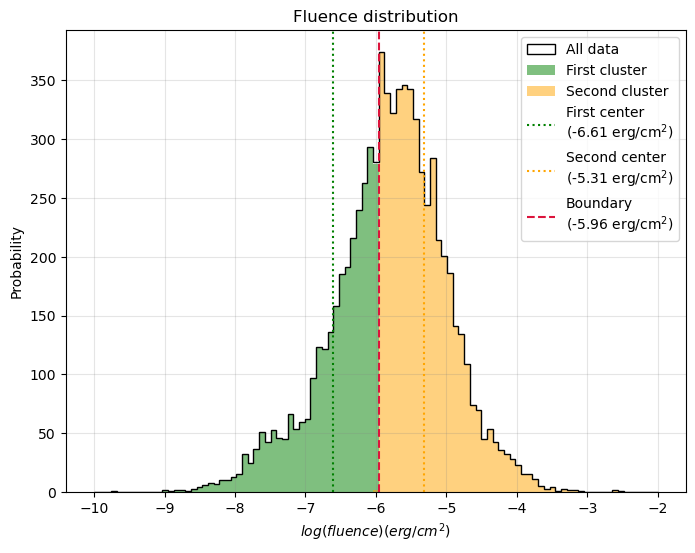

In [118]:
centers_km_f = clf_f.cluster_centers_ #Location of the centers of the two clusters
labels_km_f = clf_f.predict(fluence_reshaped) #Labels for each of the points
print('Centers without squeeze:', centers_km_f)
centers_km_f = np.squeeze(centers_km_f)

if centers_km_f[0]>centers_km_f[1]:
    centers_km_f=centers_km_f[::-1] # Reverse array
    labels_km_f = np.array(~np.array(labels_km_f,dtype='bool'),dtype='int') # Swap 0 <--> 1
print('Correct centers order:', centers_km_f)

#Boundary of the two samples
boundary_km_f = (np.mean( [max(fluence_reshaped[labels_km_f==0]), min(fluence_reshaped[labels_km_f==1]) ]))

print(max(fluence_reshaped[labels_km_f==0]), min(fluence_reshaped[labels_km_f==1]), boundary_km_f, centers_km_f)

fig13 = plt.figure(figsize=(8,6))
ax13 = fig13.gca()
ax13.grid(c='grey', alpha = 0.2)
ax13.set_title('Fluence distribution')
ax13.set_xlabel('$log(fluence)(erg/cm^2)$')
ax13.hist(fluence_reshaped, bins=np.linspace(-10, -2, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
ax13.set_ylabel('Probability')
    
ax13.hist(fluence_reshaped[labels_km_f==0], bins=np.linspace(-10, -2, 100), color='green', alpha = 0.5, label = 'First cluster')
ax13.hist(fluence_reshaped[labels_km_f==1], bins=np.linspace(-10, -2, 100), color='orange', alpha = 0.5, label = 'Second cluster')

ax13.axvline(centers_km_f[0], c= 'green', ls='dotted', label = 'First center\n(%.2f erg/cm$^2$)' % centers_km_f[0])
ax13.axvline(centers_km_f[1], c= 'orange', ls='dotted', label = 'Second center\n(%.2f erg/cm$^2$)' % centers_km_f[1])

ax13.axvline(boundary_km_f,c='crimson',ls='dashed', label = 'Boundary\n(%.2f erg/cm$^2$)' % boundary_km_f)

ax13.legend()


But in K-means we require to find two clusters, what about the Mean-shift clustering method?

In [119]:
#Mean-shift Clustering
scale_ = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(fluence_reshaped)
ms_f = MeanShift(bandwidth=bandwidth)
ms_f.fit(scaler.fit_transform(fluence_reshaped))

MeanShift(bandwidth=0.5190493481486905)

Il numero di clusters trovati è: 4


C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3360128156.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax14.axvline(centers_ms_f[0], c= 'green', ls='dotted', label = 'First center\n(%.2f s)' % centers_ms_f[0])
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3360128156.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax14.axvline(centers_ms_f[1], c= 'orange', ls='dotted', label = 'Second center\n(%.2f s)' % centers_ms_f[1])
C:\Users\ISAFA\AppData\Local\Temp\ipykernel_8364\3360128156.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single

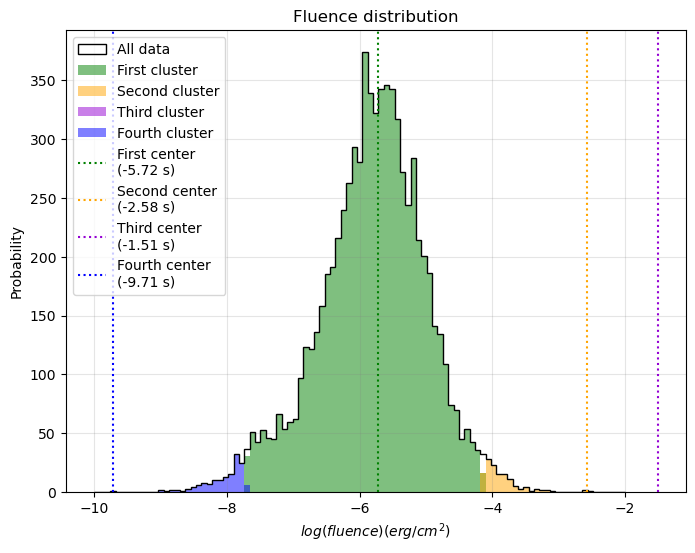

In [128]:
scaled_centers_ms_f = ms_f.cluster_centers_ #Location of the centers of the two clusters
labels_ms_f = ms_f.labels_ #Labels for each of the points

centers_ms_f = scaler.inverse_transform(scaled_centers_ms_f)
print('Il numero di clusters trovati è:', len(centers_ms_f))
#if centers_ms[0]>centers_ms[1]:
#    centers_ms=centers_ms[::-1] # Reverse array
#    labels_ms = np.array(~np.array(labels_ms,dtype='bool'),dtype='int') # Swap 0 <--> 1
#print('Correct centers order:', centers_ms)

#Boundary of the two samples
#boundary_ms = (np.mean( [max(T90_reshaped[labels_ms==0]), min(T90_reshaped[labels_ms==1]) ]))

#print(max(fluence_reshaped[labels_ms_f==0]), min(fluence_reshaped[labels_ms_f==1]), centers_ms_f)

fig14 = plt.figure(figsize=(8,6))
ax14 = fig14.gca()
ax14.grid(c='grey', alpha = 0.2)
ax14.set_title('Fluence distribution')
ax14.set_xlabel('$log(fluence)(erg/cm^2)$')
ax14.hist(fluence_reshaped, bins=np.linspace(-10, -2, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
ax14.set_ylabel('Probability')
    
ax14.hist(fluence_reshaped[labels_ms_f==0], bins=np.linspace(-10, -2, 100), color='green', alpha = 0.5, label = 'First cluster')
ax14.hist(fluence_reshaped[labels_ms_f==1], bins=np.linspace(-10, -2, 100), color='orange', alpha = 0.5, label = 'Second cluster')
ax14.hist(fluence_reshaped[labels_ms_f==2], bins=np.linspace(-10, -2, 100), color='darkviolet', alpha = 0.5, label = 'Third cluster')
ax14.hist(fluence_reshaped[labels_ms_f==3], bins=np.linspace(-10, -2, 100), color='blue', alpha = 0.5, label = 'Fourth cluster')

ax14.axvline(centers_ms_f[0], c= 'green', ls='dotted', label = 'First center\n(%.2f s)' % centers_ms_f[0])
ax14.axvline(centers_ms_f[1], c= 'orange', ls='dotted', label = 'Second center\n(%.2f s)' % centers_ms_f[1])
ax14.axvline(centers_ms_f[2], c= 'darkviolet', ls='dotted', label = 'Third center\n(%.2f s)' % centers_ms_f[2])
ax14.axvline(centers_ms_f[3], c= 'blue', ls='dotted', label = 'Fourth center\n(%.2f s)' % centers_ms_f[3])

#ax9.axvline(boundary_ms_f,c='crimson',ls='dashed', label = 'Boundary\n(%.2f s)' % 10**boundary_ms_f)

ax14.legend()

This clusterin method gives us four clusters and the purple one is even not visible. We can say that the best variable that shows the bimodality is the T90.